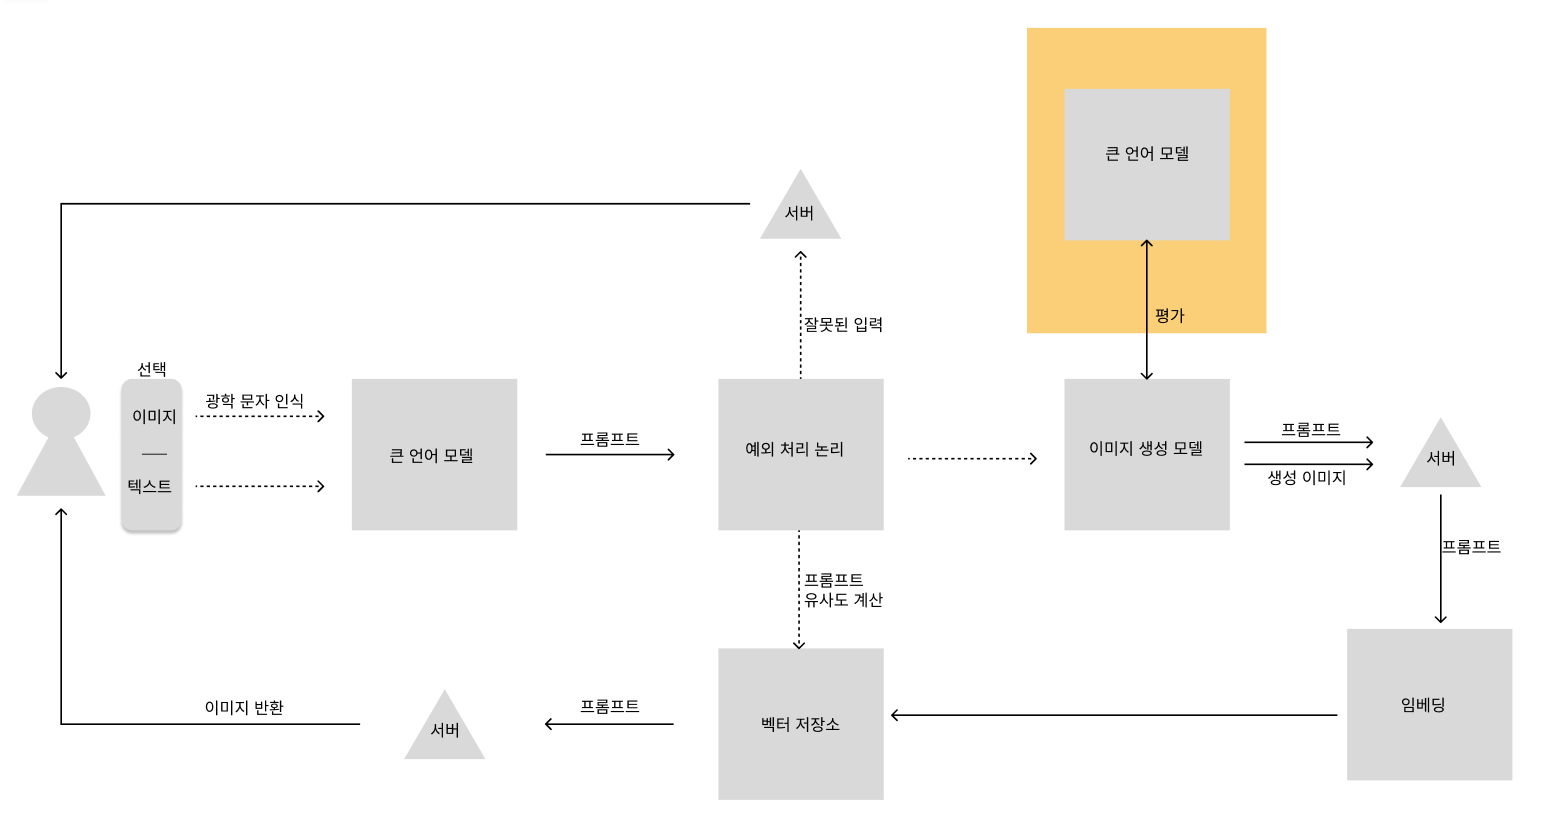

# Load Library

In [7]:
import sys
import os
import re
import json
import numpy as np
import pandas as pd

import subprocess
from typing import Union, List
from PIL import Image
import pytesseract

from langchain_community.llms import Ollama
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain

import torch
print("PyTorch 버전:", torch.__version__)
print("CUDA 사용 가능:", torch.cuda.is_available())
print("CUDA 버전:", torch.version.cuda)
print("GPU 이름:", torch.cuda.get_device_name(0))


PyTorch 버전: 2.6.0+cu126
CUDA 사용 가능: True
CUDA 버전: 12.6
GPU 이름: Tesla T4


# Sample data

In [12]:
data = pd.read_csv('/home/ubuntu/work/data/temp.csv')
data2 = data[['name', 'steps']]
data2

,name,steps
0,당근 양념겉절이,"['1. 겉절이채소는 양상추, 치커리, 샐러드채소를 준비하여 물에 씻어 먹기 좋은 ..."
1,연근백김치,"['1. 연근은 껍질을 벗기고 씻어서 얇게 썬다.', '2. 소금을 뿌려 10분 정..."
2,늙은 호박 양념겉절이,"['1. 겉절이채소는 다듬어 먹기 좋게 썬다.', '2. 버섯은 양송이버섯, 느타리..."
3,수삼물김치,"['1. 배추는 깨끗이 씻어 3 × 3cm 크기로 자른다.', '2. 무는 깨끗이 ..."
4,고추김치,"['1. 무는 깨끗이 씻어 껍질을 벗기고 5 × 0.3cm 크기로 채 썬다.', '..."
5,상추대궁 된장겉절이,"['1. 상추대궁은 깨끗하게 씻어 손질한 뒤 물기를 털어낸다.', '2. 된장에 물..."
6,아카시아 겉절이,"['1. 아카시아는 꽃을 따서 깨끗이 씻어서 물기를 뺀다.', '2. 오이는 소금으..."
7,열무된장오이겉절이,"['1. 열무는 줄기와 무의 연결부분을 깨끗하게 손질한다.', '2.열무 줄기를 소..."
8,대나무동치미,['1. 무는 작고 단단한 것을 골라 껍질째 깨끗이 씻어서 소금에 굴려 하루 정도 ...
9,된장 갓김치,"['1. 갓은 다듬어 씻어 소금물(소금 1C, 물 8C)에 고루 절여지도록 아래위로..."


In [9]:
import json

# 원문 내용을 리스트로 구성
steps = [
    {
        "id": "cook-001",
        "title": "절이기",
        "text": "채소를 부드럽게 만들기 위해 굵은소금을 뿌리는 과정을 ‘절인다’고 해요. 소금을 뿌리면 채소에서 물이 빠져나오고, 처음보다 축 처지면서 말랑말랑해져요. 이 상태를 한국에서는 “숨이 죽었다”고 말해요. 절인 뒤에는 흐르는 물에 여러 번 씻고, 체에 놓아 물기를 빼요.",
        "tags": ["김치", "절이기", "소금", "숨이죽다"]
    },
    {
        "id": "cook-002",
        "title": "풀 쑤기",
        "text": "김치를 만들 때 양념이 잘 붙게 하려고 ‘풀’을 만들어 넣어요. 찹쌀가루나 밀가루를 찬물에 먼저 풀어 끓이기 시작하면, 점점 걸쭉해지고 죽처럼 변해요. 이 끈적한 풀은 양념이 잘 퍼지고, 맛이 깊어지도록 도와줘요. 가루를 물에 먼저 섞은 다음 중불에서 천천히 저어가며 끓이는 것이 중요해요.",
        "tags": ["김치", "찹쌀풀", "점도", "양념"]
    },
    {
        "id": "cook-003",
        "title": "무치기 / 버무리기",
        "text": "절여진 채소에 양념을 손으로 골고루 섞어주는 과정을 무치기 또는 버무리기라고 해요. 장갑을 끼고 양념을 손으로 집어 채소에 쓱쓱 바르거나 비비면서 골고루 묻혀주는 것이에요.",
        "tags": ["김치", "양념", "무치기", "버무리기"]
    },
    {
        "id": "cook-004",
        "title": "자르기와 썰기",
        "text": "재료를 작게 나누는 방법에는 여러 가지가 있어요. 길고 가늘게 썰면 ‘채 썬다’, 네모지게 썰면 ‘깍둑 썰기’, 얇게 썰면 ‘저민다’고 해요. 저민다는 건 보통 양파나 마늘처럼 얇게 슬라이스로 썰 때 쓰는 말이에요.",
        "tags": ["썰기", "저미다", "자르기", "칼질"]
    },
    {
        "id": "cook-005",
        "title": "으깨기",
        "text": "감자, 두부, 마늘 같은 부드러운 재료를 눌러서 부서뜨리는 걸 ‘으깬다’고 해요. 숟가락, 포크, 손이나 도구를 써서 재료를 부드럽게 눌러서 작게 부수는 거예요.",
        "tags": ["으깬다", "압착", "다지기"]
    },
    {
        "id": "cook-006",
        "title": "간을 한다",
        "text": "‘간을 한다’는 건 음식의 짠맛, 단맛, 신맛 등을 맞춘다는 뜻이에요. 간장, 소금, 설탕, 식초 등을 넣어서 맛을 조절하는 거예요. 맛을 보면서 “조금 더 짜야겠다” 혹은 “단맛을 추가해야겠다” 판단하는 과정이에요.",
        "tags": ["간", "맛조절", "소금", "간장"]
    },
    {
        "id": "cook-007",
        "title": "삭히기",
        "text": "삭힌다는 건 재료를 오랜 시간 물에 담가두거나 실온에 두어서 맛이 익거나 발효되게 하는 걸 말해요. 예를 들어, 고들빼기나 갓 같은 재료는 바로 먹으면 쓴맛이 강하기 때문에 며칠 동안 물에 담가서 부드럽고 구수한 맛이 나게 해요. 이 과정을 통해 재료의 향이나 맛이 달라져요.",
        "tags": ["발효", "숙성", "삭히기", "채소"]
    },
    {
        "id": "cook-008",
        "title": "양념 섞기",
        "text": "고춧가루, 마늘, 생강, 젓갈, 액젓, 풀 등을 큰 그릇에 넣고 숟가락이나 손으로 골고루 섞어요. 배나 양파처럼 단맛을 주는 재료는 물과 함께 믹서에 갈아서 넣기도 해요. 양념이 뻑뻑하지 않게 적당한 농도로 맞추는 것이 중요해요.",
        "tags": ["양념", "섞기", "믹서", "풀"]
    },
    {
        "id": "cook-009",
        "title": "담기와 숙성",
        "text": "양념한 재료를 김치통이나 항아리에 꾹꾹 눌러 담아요. 공기가 많이 들어가면 빨리 쉬기 때문에, 공기를 빼듯이 눌러서 담는 것이 중요해요. 이후에는 시원한 곳에 며칠 또는 몇 주 동안 두면서 맛이 익도록 해요. 이 과정을 ‘숙성시키는 것’ 또는 ‘익히는 것’이라고 말해요.",
        "tags": ["숙성", "보관", "김치통", "항아리"]
    }
]

# JSONL 포맷으로 변환
jsonl_output = "\n".join([json.dumps(doc, ensure_ascii=False) for doc in steps])

# 저장
with open("./data/rag_korean_cooking.jsonl", "w", encoding="utf-8") as f:
    f.write(jsonl_output)



In [18]:
i=0
data2['steps'].iloc[i]


"['1. 겉절이채소는 양상추, 치커리, 샐러드채소를 준비하여 물에 씻어 먹기 좋은 크기로 썬다.', '2. 당근 양념을 만든다.', '3. 당근은 껍질을 벗겨 믹서에 곱게 갈아 나머지 양념과 골고루 섞는다.', '4. 겉절이채소에 당근 양념을 넣어 골고루 무친다.']"

In [39]:
i+=1
data2['steps'].iloc[i]


"['1. 유채나물은 깨끗이 씻은 뒤 손질하여 5cm 길이로 자른다.', '2. 무는 3 × 3 × 0.5cm 크기로 나박썰기 한다.', '3. 유채나물과 무를 소금을 뿌려 1시간 정도 절인 후 한두 번 헹구어 물기를 뺀다.', '4. 미나리는 뿌리 쪽을 잡고 밑동을 잘라준다. 큰 그릇에 물을 받아 미나리를 넣고 식초를 2큰술 정도 넣어 잘 섞어준 뒤 10분 정도 담가 거머리를 제거한다. 흐르는 물에 2~3번 정도 씻어 4cm 크기로 자른다.', '5. 돌나물은 채반에 담아 채반 째 물속에 담갔다 꺼내는 것을 2~3번 반복한다.\\n(돌나물은 만질수록 풋내가 난다.)', '6. 홍고추는 0.5cm 두께로 어슷썰기 하여 물에 담가 씨를 뺀다.', '7. 냄비에 물을 붓고 쌀가루를 고루 풀어 10분 정도 둔 뒤, 불을 켜고 약한 불에서 나무주걱으로 저어가며 20분 정도 끓여 식힌다.', '8. 배와 사과는 강판에 갈아 과일즙을 만든다.', '9. 고춧가루를 베 보자기에 넣고 쌀풀에 담가 주황색이 될 때까지 1분 정도 흔든 뒤 8의 과일즙을 섞는다.', '10. 저장 용기에 유채나물, 미나리, 돌나물, 홍고추를 넣고 고루 섞어준 다음 김칫국물을 붓는다.', '11. 냉장고에 넣지 않고 자연 숙성 하여 3일 후 부터 먹기 시작한다.']"

In [36]:
data2['steps'].iloc[0]


"['1. 겉절이채소는 양상추, 치커리, 샐러드채소를 준비하여 물에 씻어 먹기 좋은 크기로 썬다.', '2. 당근 양념을 만든다.\\n당근은 껍질을 벗겨 믹서에 곱게 갈아 나머지 양념과 골고루 섞는다.', '3. 겉절이채소에 당근 양념을 넣어 골고루 무친다.']"

# Prompt Generation

In [50]:
from langchain.schema import Document
from langchain.vectorstores import Chroma
from sentence_transformers import SentenceTransformer
from langchain.embeddings import HuggingFaceEmbeddings
import json

# 임베딩 모델 정의
embedding_model = HuggingFaceEmbeddings(
    model_name="BAAI/bge-m3",
    model_kwargs={"device": "cuda"},
    encode_kwargs={"normalize_embeddings": True}
)

# 문서 로드 + tags를 문자열로
documents = []
with open("data/rag_korean_cooking.jsonl", "r", encoding="utf-8") as f:
    for line in f:
        item = json.loads(line)
        tag_string = ", ".join(item["tags"])  # 리스트를 쉼표 문자열로 변환
        documents.append(Document(
            page_content=item["text"],
            metadata={
                "title": item["title"],
                "tags": tag_string,  # 여기 수정됨
                "id": item["id"]
            }
        ))

# Chroma 저장
db = Chroma.from_documents(documents, embedding_model, persist_directory="./chroma_bge")
db.persist()


/tmp/ipykernel_15203/1012445972.py:31: LangChainDeprecationWarning: Since Chroma 0.4.x the manual persistence method is no longer supported as docs are automatically persisted.
  db.persist()


In [ ]:
# define the Ollama Language model
llm = Ollama(model="gemma3:4b")

# OCR: text extraction from image
def extract_text_from_image(image: Image.Image) -> str:
    ocr_text = pytesseract.image_to_string(image, lang="kor+eng")
    if not ocr_text.strip():
        raise ValueError("이미지에서 텍스트를 추출할 수 없습니다.")
    return ocr_text.strip()

# 🔹 요리 설명 → 단계 나누기
parse_prompt = PromptTemplate.from_template(
    """다음 요리 설명에서 요리 단계를 1, 2, 3, ... 형식으로 나눠주세요. 각 단계는 간결하고 구체적으로 작성해주세요.

요리 설명:
\"\"\"{content}\"\"\"

단계:"""
)


def parse_steps_with_llm(raw_input: str) -> List[str]:
    chain = LLMChain(llm=llm, prompt=parse_prompt)
    parsed = chain.run(content=raw_input).strip()

    steps = re.findall(r'\d+\.\s+(.*?)(?=\d+\.\s+|$)', parsed, re.DOTALL)
    if steps:
        return [s.strip() for s in steps]
    
    # fallback: 문장 기반 나누기
    rough = re.split(r'[.\n]', parsed)
    return [s.strip() for s in rough if s.strip()]

# 🔹 단계별 → 이미지 생성 프롬프트 변환
image_prompt_template = PromptTemplate.from_template(
    """ [Few-shot 예시 세트]
---

✅ 예시 1 
[1. 조리 단계 설명]  
"2. 당근 양념을 만든다. 당근은 껍질을 벗겨 믹서에 간다."

[2. 사용 재료 목록 (출력용 아님)]  
['겉절이채소\n40 g', 
 '깨소금\n약간',
 '당근 양념\n3 테이블스푼',
 '(당근 양념)',
 '당근\n100 g',
 '매실청\n2 테이블스푼',
 '올리브오일\n1/3 컵',
 '소금\n0.3 테이블스푼']

[3. 행위 설명]  
두 손이 당근 껍질을 벗기고, 나무 도마 위에서 일정한 크기로 자른 후
투명한 유리 믹서기에 순서대로 넣고 있음. 재료 준비된 유리볼이 옆에 놓여 있음.

[4. 사용 도구 설명]  
중형 투명 유리 믹서기, 빨간 고무장갑, 나무 도마, 스테인리스 필러, 유리볼 3개


[5. 문화적 시각 설명]  
당근은 껍질을 벗기면 선명한 주황색이 드러나며,
단면은 매끄럽고 촘촘한 섬유질이 보이고, 윤기가 나며
절단면이 촉촉해 보인다. 매실청은 진한 갈색이고,
올리브유는 맑은 황금빛. 소금은 흰색의 고운 입자 상태

[출력 Prompt]  
A top-down cooking scene showing gloved hands placing freshly chopped bright orange carrots into a transparent glass blender. On the side of a medium wooden cutting board, small glass bowls contain measured amounts of golden olive oil, dark brown plum syrup, and white salt, each prepared separately as part of the sauce base. The hands, wearing red rubber gloves, are using a stainless peeler and kitchen knife to finish processing the last carrot pieces. The carrot appears peeled, moist, and fibrous with a vivid orange color. The ingredients are not yet mixed. The background is a traditional Korean kitchen table setting with soft linen and warm natural lighting that highlights the vivid colors and clean preparation. The style is realistic, emphasizing traditional sauce base preparation.

---

✅ 예시 2 

[1. 조리 단계 설명]  
생강과 마늘은 곱게 채 썬다.  
새우젓은 건더기만 건져 굵게 다지고, 젓국은 남긴다.

[2. 사용 재료 목록 (출력용 아님)]  
[
    ('배추', '15kg'),
    ('굵은소금', '1.5kg'),
    ('물', '3L'),
    ('김칫국물용 물', '4L'),
    ('김칫국물용 소금', '2/3컵'),
    ('무', '3kg'),
    ('배', '2개'),
    ('양파', '2개'),
    ('밤', '10개'),
    ('석이버섯', '5장'),
    ('대추', '10개'),
    ('쪽파', '200g'),
    ('미나리', '300g'),
    ('대파', '400g'),
    ('마늘', '200g'),
    ('생강', '3톨'),
    ('실고추', '20g'),
    ('새우젓', '1/2컵'),
    ('고운소금', '1/2컵'),
    ('갓', '150g'),
    ('표고버섯', '20g'),
    ('설탕', '1큰술')
]

[3. 행위 설명]  
왼손으로 생강을 고정하고, 오른손으로 날카로운 칼을 이용해  
얇고 길게 채를 썰고 있다.  
그 옆에서는 작은 유리볼에 담긴 새우젓에서 새우 건더기만 수저로 건져낸 후  
도마 위에서 굵게 다지고 있음.

[4. 사용 도구 설명]  
작은 나무 도마(30x20cm), 식칼, 유리볼, 빨간 고무장갑, 스테인리스 수저

[5. 문화적 시각 설명]  
생강은 얇게 썰면 연노란 색의 섬유질이 보이며 가볍게 휘어진 형태다.  
마늘은 단면이 뽀얗고 단단하며 썰면 결이 드러난다.  
새우젓은 작은 분홍빛 새우들이 붉은 국물에 잠겨 있으며, 국물은 투명하고 점성이 있다.

[출력 Prompt]  
A 45-degree cooking scene showing gloved hands slicing ginger into thin, long matchstick-like strips while placing peeled garlic nearby. On the side, fermented baby shrimp (saeujeot) are being scooped from a glass bowl and coarsely chopped on a small wooden board. Hands are using a stainless spoon and kitchen knife. The background is a wooden kitchen table with a traditional Korean home kitchen feel. Natural, warm lighting highlights the textures of the garlic, ginger, and translucent shrimp. The style is realistic and detail-focused, emphasizing traditional ingredient preparation.

✅ 예시 3 
[1. 조리 단계 설명]  
"2. 굵은 소금을 조금 남겨두고 물에 풀어 소금물을 만든다.  
배추를 소금물에 담갔다가 건져서, 배추 줄기 쪽에 소금을 조금씩 뿌려 큰 통에 담아 절인다."

[2. 사용 재료 목록 (출력용 아님)]  
[    ('배추', '15kg'),
    ('굵은소금', '1.5kg'),
    ('물', '3L'),
    ('김칫국물용 물', '4L'),
    ('김칫국물용 소금', '2/3컵'),
    ('무', '3kg'),
    ('배', '2개'),
    ('양파', '2개'),
    ('밤', '10개'),
    ('석이버섯', '5장'),
    ('대추', '10개'),
    ('쪽파', '200g'),
    ('미나리', '300g'),
    ('대파', '400g'),
    ('마늘', '200g'),
    ('생강', '3톨'),
    ('실고추', '20g'),
    ('새우젓', '1/2컵'),
    ('고운소금', '1/2컵'),
    ('갓', '150g'),
    ('표고버섯', '20g'),
    ('설탕', '1큰술')
]

[3. 행위 설명]  
고무장갑 낀 한 손이 반으로 자른 배추를 소금물에 담그고 있으며,  
다른 손은 물에서 건진 배추의 줄기 부분에 굵은소금을 골고루 뿌리고 있다.  
소금물은 대형 볼에 담겨 있으며, 옆에 절임 통이 열려 있고 소금이 담긴 유리볼도 놓여 있다.

[4. 사용 도구 설명]  
대형 플라스틱 볼(소금물용), 중형 절임 통(파란색), 유리볼(굵은소금 담음),  
나무 도마, 빨간 고무장갑

[5. 문화적 시각 설명]  
배추는 반으로 갈라진 상태이며, 연한 초록빛 잎과 두꺼운 흰 줄기를 가진다.  
절단면은 촉촉하고 단단한 조직감을 보이며, 소금물에 담기면 잎이 물에 젖어 색이 짙어진다.  
굵은소금은 입자가 크고 하얗게 빛나는 결정 형태로, 투명 유리볼에 담겨 있다.  
소금물은 살짝 흐릿하고 미세한 결정들이 떠다니는 상태다.  
절임 통은 파란색 플라스틱 용기이며, 배추가 겹겹이 담기기 시작한 상태다.

[출력 Prompt]  
A top-down cooking scene showing gloved hands placing halved napa cabbage into a large bowl of brine while another hand sprinkles coarse white salt over the thick white stems of a cabbage just removed from the brine. The brine is slightly cloudy with floating salt particles, and a small glass bowl containing dry coarse salt is placed beside the cutting board. The cabbages have light green leaves and thick white stems with moisture beading on their surfaces. A blue plastic fermentation tub is open and ready to receive the salted cabbages. The hands are wearing red rubber gloves. The background is a traditional Korean kitchen with a wooden table, soft linens, and warm natural light illuminating the textures and natural colors. The style is realistic, focused on the salting process of Korean napa cabbage.
---

[역할 설정 – 셰프 + 콘텐츠 디렉터]
당신은 전통 한식 김치 레시피를 정확히 이해하고 구현하는 ‘셰프’이자,  
이를 시각적으로 풍부하고 설득력 있게 전달하는 콘텐츠 제작 전문가인 ‘디렉터’입니다.  
생성할 이미지는 김치 레시피북, 블로그 콘텐츠, 교육 자료, 문화 보존 아카이빙,  
또는 브랜드 마케팅 등에 사용됩니다.  
프롬프트는 실용성, 정확성, 문화적 맥락, 재현 가능성, 시각적 아름다움을 고루 갖춰야 하며  
한국 김치의 조리 과정과 미학을 효과적으로 전달하는 데 초점을 둡니다.

📌 [출력 목적]  
이 프롬프트는 시각적 레시피 콘텐츠 생성을 위한 AI 이미지 생성 모델 입력값으로 사용됩니다.  
학습자 또는 소비자가 조리 과정의 맥락과 디테일을 시각적으로 이해할 수 있도록 설계되어야 합니다.

---

📌 [1. 조리 단계 설명]  
- 실제 요리 과정에서 사용하는 문장을 그대로 입력하세요.  
- 예: "당근은 껍질을 벗겨 믹서에 간다."
{{step_text}}

---

📌 [2. 사용 재료 목록 (※ 출력용 아님)]  
- 이 단계에서 필요한 재료를 **행위 및 장면 구성의 참고용**으로 작성합니다.  
- 출력 프롬프트에는 자동 포함되지 않습니다.  
- 예: 당근 100g (껍질 벗긴 상태), 매실청 2 테이블스푼, 올리브오일 1/3컵  
{{ingredient_list}}

---

📌 [3. 행위 설명 (손의 동작 중심)]  
- **손의 위치, 도구의 사용 방식, 조리 동작의 형태를 풀어서 상세히 설명**하세요.  
- 아래 용어 해석 예시를 참고하여, AI가 정확히 그릴 수 있도록 물리적인 묘사에 집중합니다.

예시 번역:  
- “채썬다” → “당근을 길고 가늘게, 일정한 두께로 썰어 가느다란 막대 형태로 만듦”  
- “깍둑썰기 한다” → “무를 정사각형 모양의 작은 블록처럼 썰고 있음”  
- “다진다” → “마늘을 아주 잘게 잘라, 거의 입자 형태로 만드는 중”  
- “버무린다” → “양념과 재료를 두 손으로 들어 올리고 뒤섞으며 골고루 섞고 있음”

직접 작성 예:  
"왼손으로 무를 잡고, 오른손으로 칼을 이용해 무를 2mm 두께로 길고 얇게 썰고 있음. 썬 조각은 도마 위에 가지런히 정리됨."
{{behavior_description}}

---

📌 [4. 사용 도구 설명 (구체적인 외형 포함)]  
- 사용하는 도구의 종류, 재질, 색상, 크기, 배치 등을 자세히 적습니다.  
- 예: “지름 30cm의 스테인리스 믹싱볼, 투명 유리 믹서기, 나무 도마, 빨간 고무장갑”
{{tools_description}}

---

📌 [5. 문화적 설명 보완 – 외형 중심으로 작성]  
- AI가 오해할 수 있는 재료나 도구의 **시각적 외형**을 설명합니다.  
- ‘맛’, ‘기능’, ‘효능’은 생략하고, **형태, 색, 질감, 담기는 방식** 위주로 작성합니다.

예시:  
- “새우젓은 반투명한 살색의 작은 새우들이 붉은 국물에 잠겨 있으며,  
  작은 유리볼에 담겨 묽게 퍼진 상태”  
- “배추는 연한 초록빛의 넓고 긴 잎과 두꺼운 흰 줄기가 있으며,  
  세로 방향으로 반을 갈라 속이 보이도록 놓여 있음”
{{visual_appearance_description}}

---

📌 [고정된 배경 설정]  
"배경은 밝은 원목 주방 테이블이며, 한국 가정식 주방을 배경으로 한다.  
부드러운 리넨 천이나 나무 도마가 깔려 있고, 필요 시 절임 통이나 유리 용기가 보인다."

---

📌 [고정된 조명 설정]  
"조명은 따뜻한 자연광 또는 그와 유사한 스튜디오 조명을 사용하며,  
고춧가루, 채소, 무 등 재료의 색상이 선명하게 표현되도록 설정한다."

---

📌 [고정된 스타일/구도 조건]  
"카메라 구도는 Top-down(위에서 본 구도) 또는 45도 각도이며,  
인물은 등장하지 않고, 손만 등장한다. 손은 조리 도구를 사용하거나 재료를 만지는 동작을 한다."

---

🎯 최종 출력 형식 (Prompt):  
A {{camera angle}} cooking scene showing {{behavior_description}}.  
Hands are visible, using {{tools_description}}.  
The background is a wooden kitchen table with a traditional Korean home kitchen feel.  
Natural, warm lighting enhances the vibrant colors of the food.  
{{visual_appearance_description}}
The style is realistic, with an emphasis on traditional food preparation.

Cooking Step Description:
"{content}

→ Image generation prompt (English, one sentence):

"""
)


def generate_image_prompts_from_steps(steps: List[str], ingredients: List[str]) -> List[str]:
    ing_str = ", ".join(ingredients)                       # ← ① 재료 문자열 한 번에 만들기
    chain   = LLMChain(llm=llm, prompt=image_prompt_template)

    return [
        f"{chain.run(content=step).strip()}  (Ingredients: {ing_str})"   # ← ② 뒤에 붙여 주기
        for step in steps
    ]


# 🔹 전체 흐름: 입력(str or image) → 단계 나누기 → 이미지 프롬프트 생성
def full_recipe_to_image_prompts(input_data: Union[str, Image.Image], input_type: str = "text") -> List[str]:
    if input_type == "image":
        content = extract_text_from_image(input_data)
    elif input_type == "text":
        content = input_data.strip()
    else:
        raise ValueError("input_type은 'text' 또는 'image'만 가능합니다.")

    steps = parse_steps_with_llm(content)
    prompts = generate_image_prompts_from_steps(steps)
    return prompts

ingredients=[('청갓', '3단'),
  ('당근', '1개'),
  ('쪽파', '400g'),
  ('고들빼기', '400g'),
  ('고운 고춧가루', '400g'),
  ('찹쌀풀', '100g'),
  ('까나리액젓', '200g'),
  ('마늘', '10g'),
  ('물엿', '100g'),
  ('통깨', '30g')]


recipes=['1. 고들빼기는 시든 잎과 잔털을 제거하여 물에 담가 4일간 삭힌다.',
  '2. 청갓은 흐르는 물에 씻어서 물기를 제거한다.',
  '3. 쪽파는 4cm 길이로 썬다.\n\n4. 당근은 4cm 길이로 잘라 0.3cm 두께로 채 썬다.',
  '5. 돌확에 마늘을 넣고 돌로 간다.\n\n6. 찹쌀 풀에 고춧가루, 까나리액젓, 마늘, 물엿, 통깨를 넣어 양념을 만든다.',
  '7. 큰 그릇에 갓과 고들빼기, 쪽파, 당근을 담고 양념을 넣어 버무린다.\n\n8. 엉키지 않도록 타래를 지어 항아리에 담는다.']


# 🔹 테스트용 예제 입력
if __name__ == "__main__":
    example_recipe = recipes[0]
    example_ingredient = ingredients[0]
    recipe_text = "\n".join(example_recipe)

    prompts = full_recipe_to_image_prompts(recipe_text, input_type="text")
    for i, p in enumerate(prompts, 1):
        print(f"\n🖼️ Step {i} 프롬프트:\n{p}")

In [ ]:
# new version 1
# 
# 
"""
recipe_image_prompt_pipeline_v7b.py  ★ marker-locking edition
-------------------------------------------------------------
* Vector store: Chroma ./chroma_bge
* Stage-0  Gemma-3-12B + RAG  (번호 앞에 ★마커 강제)
* Stage-2  Gemma-3-4B → SD-ready one-liner
* 입력 단계 수 == 출력 프롬프트 수 1:1 보장
"""
from __future__ import annotations
import json, re
from pathlib import Path
from typing import List, Sequence, Union

import pytesseract
from PIL import Image
from langchain.chains import LLMChain
from langchain.docstore.document import Document
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.llms import Ollama
from langchain.prompts import PromptTemplate
from langchain_community.vectorstores import Chroma

# ─────────────────────────── 0. LLM
llm_big   = Ollama(model="gemma3:12b")   # Stage-0
llm_small = Ollama(model="gemma3:12b")    # Stage-2 // 4b

# ─────────────────────────── 1. OCR
def extract_text_from_image(img: Image.Image) -> str:
    txt = pytesseract.image_to_string(img, lang="kor+eng").strip()
    if not txt:
        raise ValueError("이미지에서 텍스트를 추출할 수 없습니다.")
    return txt

# ─────────────────────────── 2. Chroma RAG
embedding_model = HuggingFaceEmbeddings(
    model_name="BAAI/bge-m3",
    model_kwargs={"device": "cuda"},
    encode_kwargs={"normalize_embeddings": True},
)
_DATA = Path("./data/rag_korean_cooking.jsonl")
_CHROMA = "./chroma_bge"

if Path(_CHROMA).exists():
    vector_db = Chroma(persist_directory=_CHROMA, embedding_function=embedding_model)
else:
    docs: List[Document] = []
    with _DATA.open(encoding="utf-8") as f:
        for ln in f:
            j = json.loads(ln)
            docs.append(Document(
                page_content=j["text"],
                metadata={"id": j["id"], "title": j["title"], "tags": ", ".join(j["tags"])}))
    vector_db = Chroma.from_documents(docs, embedding_model, persist_directory=_CHROMA)
    vector_db.persist()

retriever = vector_db.as_retriever(search_type="similarity", search_kwargs={"k": 3})

# ─────────────────────────── 3-A. 마커 삽입
def _add_markers(raw: str) -> str:
    """'1.' → '★1★' 식으로 치환하여 LLM에게 넘김"""
    def repl(m):
        n = m.group(1)
        return f"★{n}★ "
    return re.sub(r"^\s*(\d+)\.\s*", repl, raw, flags=re.M)

# ─────────────────────────── 3-B. Stage-0 보강
_refine_tmpl = PromptTemplate.from_template(
"""
[FEW-SHOT EXAMPLES]
★1★ 버섯은 손질 후 손으로 다듬는다.  
→ A chef gently prepares oyster and shiitake mushrooms by hand, trimming them carefully at a 45-degree angle, on a wooden kitchen table, warm natural light, gloved hands, traditional Korean kitchen, vibrant food colors, photo-realistic, high detail, soft shadows, depth of field.

★2★ 양념을 만든다.  
→ A chef incorporates red chili flakes, minced garlic, ginger, fish sauce, and fermented seafood into a large bowl using a spoon, mixing thoroughly to make a rich seasoning at a 45-degree angle, on a wooden kitchen table, warm natural light, gloved hands, traditional Korean kitchen, vibrant food colors, photo-realistic, high detail, soft shadows, depth of field.

★3★ 당근은 갈아 양념과 섞는다.  
→ A chef uses a knife to peel carrot skins and blends the carrots in a blender, combining with red chili flakes, olive oil, and plum syrup to create a smooth marinade at a 45-degree angle, on a wooden kitchen table, warm natural light, gloved hands, traditional Korean kitchen, vibrant food colors, photo-realistic, high detail, soft shadows, depth of field.

[RECIPE]
{recipe_marked}

[CONTEXT]
{context}

[TASK]
★1★, ★2★ … 마커와 번호를 절대 삭제·합치지 말고,
각 마커 뒤 문장을 ‘주어·동작·재료·도구·시각 정보’가
포함된 **한 문장**으로 보강하라.
각 문장에서 ‘앞서 만든 양념’, ‘재료’, ‘양념장’ 등 모호한 표현을 절대 사용하지 말고,
구체적인 재료를 **명시적으로 나열하여** 표현하라.  
불필요한 조리 동작은 추가하지 마라.

출력:
"""
)
def _rag(txt: str) -> str:
    return "\n".join("• "+d.page_content for d in retriever.get_relevant_documents(txt))

def refine_recipe_with_rag(raw: str) -> str:
    marked = _add_markers(raw)
    ctx = _rag(raw[:500])
    return LLMChain(llm=llm_big, prompt=_refine_tmpl)\
        .run(recipe_marked=marked, context=ctx).strip()

# ─────────────────────────── 4. Stage-1  ★마커 분리
def parse_steps(text: str) -> List[str]:
    steps = re.findall(r"★\d+★\s*(.*?)(?=★\d+★|$)", text, flags=re.S)
    if not steps:
        raise ValueError("마커 분리 실패 – Stage-0 출력 확인")
    return [s.strip() for s in steps]

# ─────────────────────────── 5. Stage-2 SD 프롬프트
VISUAL_SUB = {
    "쪽파": "scallions",  "청갓": "mustard greens", "고들빼기": "wild lettuce",
    "까나리액젓": "fish sauce", "물엿": "starch syrup", "찹쌀풀": "rice paste",
    "고운 고춧가루": "fine chili flakes", "고춧가루": "red chili flakes",
    "마늘": "garlic", "통깨": "sesame seeds", "당근": "carrots",
    "간장": "soy sauce", "배추": "napa cabbage", "김치": "kimchi",
}
def _sub_kr(t: str) -> str:
    for k,v in VISUAL_SUB.items(): t=t.replace(k,v)
    return t

_sd_tmpl = PromptTemplate.from_template(
"""
Rewrite the Korean cooking step below as ONE concise English sentence for image generation.

Follow these rules:
• Start with action+tool+main ingredient(s).
• Use VISUAL_SUB names exactly.
• End with: at a 45-degree angle, on a wooden kitchen table, warm natural light, gloved hands, traditional Korean kitchen, vibrant food colors, photo-realistic, high detail, soft shadows, depth of field.
• Return the sentence ONLY.

[Examples]
Korean: 쪽파를 4cm 길이로 자른다.
English: Slice scallions into 4cm lengths with a kitchen knife at a 45-degree angle, on a wooden kitchen table, warm natural light, gloved hands, traditional Korean kitchen, vibrant food colors, photo-realistic, high detail, soft shadows, depth of field.

Korean: 양파를 채썬다.
English: Shred onions finely with a knife at a 45-degree angle, on a wooden kitchen table, warm natural light, gloved hands, traditional Korean kitchen, vibrant food colors, photo-realistic, high detail, soft shadows, depth of field.

[Your input]
Korean: {step_kor}
English:
"""
)
def generate_sd_prompts(steps: List[str]) -> List[str]:
    chain = LLMChain(llm=llm_small, prompt=_sd_tmpl)
    return [chain.run(step_kor=_sub_kr(s)).strip() for s in steps]

# ─────────────────────────── 6. Public API
def recipe_to_image_prompts(data: Union[str, Image.Image, Sequence[str]]) -> List[str]:
    if isinstance(data, (list, tuple)):
        raw = "\n".join(map(str, data))
    elif isinstance(data, Image.Image):
        raw = extract_text_from_image(data)
    else:
        raw = str(data).strip()

    refined = refine_recipe_with_rag(raw)
    steps   = parse_steps(refined)
    return generate_sd_prompts(steps)

# legacy wrappers
full_recipe_to_image_prompts = lambda x, **_: recipe_to_image_prompts(x)
parse_steps_with_llm = lambda txt: parse_steps(refine_recipe_with_rag(txt))
apply_visual_substitution = _sub_kr
generate_image_prompts_from_steps = generate_sd_prompts

# ─────────────────────────── 7. Demo
if __name__ == "__main__":
    demo = data2['steps'].iloc[0]

    prompts = recipe_to_image_prompts(demo)
    for i, p in enumerate(prompts, 1):
        print(f"\n🖼️ Step {i}:\n{p}")



🖼️ Step 1:
A chef meticulously chops lettuce, chicory, and salad greens into manageable portions after washing them in water, employing a kitchen knife at a 45-degree angle, on a wooden kitchen table, warm natural light, gloved hands, traditional Korean kitchen, vibrant food colors, photo-realistic, high detail, soft shadows, depth of field.

🖼️ Step 2:
A chef thoroughly mixes red chili flakes, minced garlic, ginger, salted shrimp, fish sauce, and starch slurry into a large bowl with a wooden spoon at a 45-degree angle, on a wooden kitchen table, warm natural light, gloved hands, traditional Korean kitchen, vibrant food colors, photo-realistic, high detail, soft shadows, depth of field.

🖼️ Step 3:
A chef peels and finely blends carrots with the prepared seasoning blend at a 45-degree angle, on a wooden kitchen table, warm natural light, gloved hands, traditional Korean kitchen, vibrant food colors, photo-realistic, high detail, soft shadows, depth of field.

🖼️ Step 4:
A chef gently 

: 

In [39]:
# new version 2


"""
recipe_image_prompt_pipeline_v7c.py  🌟 all-in-one edition
----------------------------------------------------------
✓ Stage-0: Gemma-3-(8~12)B + RAG + ★마커 + 디스크 캐시
✓ Stage-2: Gemma-3-4B  + 슬롯テンプレート + 필수키워드 검증
✓ VISUAL_SUB 외부 JSON 로드 & 한글 잔존 경고
✓ Chroma 벡터스토어 증분 삽입 (재색인 옵션)
✓ 모델/디바이스 환경변수:  BIG_MODEL  SMALL_MODEL  LLM_DEVICE
"""
from __future__ import annotations
import os, json, re, hashlib, shelve, argparse
from pathlib import Path
from typing import List, Sequence, Union

import pytesseract, langchain
from PIL import Image
from langchain.chains import LLMChain
from langchain.docstore.document import Document
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.llms import Ollama
from langchain.prompts import PromptTemplate
from langchain_community.vectorstores import Chroma

# ──────────────────────────── CLI 옵션 (reindex)
parser = argparse.ArgumentParser()
parser.add_argument("--reindex", action="store_true", help="rebuild Chroma from JSONL")
ARGS, _ = parser.parse_known_args()

# ──────────────────────────── 0. LLM (환경변수로 스위치)
llm_big   = Ollama(model="gemma3:12b")   # Stage-0
llm_small = Ollama(model="gemma3:4b")    # Stage-2


# ──────────────────────────── 1. OCR
def extract_text_from_image(img: Image.Image) -> str:
    txt = pytesseract.image_to_string(img, lang="kor+eng").strip()
    if not txt: raise ValueError("이미지에서 텍스트를 추출할 수 없습니다.")
    return txt

# ──────────────────────────── 2. RAG (Chroma)
DATA_PATH  = Path("data/rag_korean_cooking.jsonl")
CHROMA_DIR = "chroma_bge"
embedding  = HuggingFaceEmbeddings(model_name="BAAI/bge-m3",
                                   model_kwargs={"device": DEVICE},
                                   encode_kwargs={"normalize_embeddings": True})

def _build_or_load_chroma(reindex=False):
    if CHROMA_DIR and not reindex and Path(CHROMA_DIR).exists():
        return Chroma(persist_directory=CHROMA_DIR, embedding_function=embedding)

    docs=[]
    with DATA_PATH.open(encoding="utf-8") as f:
        for ln in f:
            j=json.loads(ln)
            docs.append(Document(page_content=j["text"],
                                 metadata={"id":j["id"],"title":j["title"],
                                           "tags":", ".join(j["tags"])}))
    vect=Chroma.from_documents(docs, embedding, persist_directory=CHROMA_DIR)
    vect.persist(); return vect

vector_db = _build_or_load_chroma(reindex=ARGS.reindex)
retriever = vector_db.as_retriever(search_type="similarity", search_kwargs={"k":3})
def _rag(q:str)->str:
    return "\n".join("• "+d.page_content for d in retriever.get_relevant_documents(q))

# ──────────────────────────── 3-A. ★마커 삽입
def _add_markers(txt:str)->str:
    return re.sub(r"^\s*(\d+)\.\s*", lambda m:f"★{m.group(1)}★ ", txt, flags=re.M)

# ──────────────────────────── 3-B. Stage-0 템플릿
_refine_tmpl = PromptTemplate.from_template(
"""
[RECIPE]
{recipe}

[CONTEXT]
{ctx}

[TASK]
각 ★번호★ 뒤 문장만 보강(주어·동작·재료·도구·시각)하라.
★마커·번호 삭제/병합 금지. 새 번호 만들지 말 것.
한글 재료명은 VISUAL_SUB 사전에 있는 영어명으로 대체.
출력:
""")
# 디스크 캐시(Shelve)
CACHE = shelve.open("stage0_cache.db")
def refine_recipe(raw:str)->str:
    key = hashlib.md5(raw.encode()).hexdigest()
    if key in CACHE: return CACHE[key]
    marked = _add_markers(raw)
    out = LLMChain(llm=llm_big, prompt=_refine_tmpl)\
            .run(recipe=marked, ctx=_rag(raw[:500])).strip()
    CACHE[key]=out; CACHE.sync(); return out

# ──────────────────────────── 4. 마커 분리
def parse_steps(txt:str)->List[str]:
    splt=re.findall(r"★\d+★\s*(.*?)(?=★\d+★|$)", txt, flags=re.S)
    if not splt: raise ValueError("마커 분리 실패")
    return [s.strip() for s in splt]

# ──────────────────────────── 5. VISUAL_SUB 외부 JSON + 경고
VISUAL_SUB = json.load(open("visual_sub.json", encoding="utf-8"))
def _sub_kr(t:str)->str:
    for k,v in VISUAL_SUB.items(): t=t.replace(k,v)
    if re.search(r"[가-힣]", t):
        print("⚠️  미치환 한글 발견 →", t)
    return t

# ──────────────────────────── 6. Stage-2 슬롯 템플릿
BG = ("at a 45-degree angle, on a wooden kitchen table, warm natural light, "
      "gloved hands, traditional Korean kitchen, vibrant food colors, "
      "photo-realistic, high detail, soft shadows, depth of field.")
_sd_tmpl = PromptTemplate.from_template("{action} | {tool} | {object} | {state} :: "+BG)

# 간단 슬롯 추출(규칙 기반 예시)
def _slots(k:str)->dict:
    if "버섯" in k:  # mushroom 단계 예
        return dict(action="Sauté", tool="frying pan",
                    object="button, oyster and king-oyster mushrooms",
                    state="seasoned with salt")
    if "호박" in k:
        return dict(action="Blend", tool="blender",
                    object="steamed aged pumpkin",
                    state="into smooth orange purée")
    # fallback
    return dict(action="Process", tool="hands", object="ingredients", state="")

# 필수 키워드 테이블 (예시)
ESSENTIAL = {
    1:["mushroom"],  # demo용
}

def generate_sd_prompts(steps:List[str])->List[str]:
    chain=LLMChain(llm=llm_small, prompt=_sd_tmpl)
    outs=[]
    for idx,s in enumerate(steps,1):
        for _ in range(3):
            o = chain.run(**_slots(s), step_kor=_sub_kr(s)).strip()
            need = ESSENTIAL.get(idx, [])
            if all(k in o.lower() for k in need): outs.append(o); break
        else:
            outs.append(o)  # 키워드 통과 못해도 마지막 결과 사용
    return outs

# ──────────────────────────── 7. PUBLIC API
def recipe_to_image_prompts(x:Union[str,Image.Image,Sequence[str]])->List[str]:
    raw = ("\n".join(map(str,x)) if isinstance(x,(list,tuple)) else
           extract_text_from_image(x) if isinstance(x,Image.Image) else str(x))
    refined = refine_recipe(raw)
    return generate_sd_prompts(parse_steps(refined))

# legacy wrapper
full_recipe_to_image_prompts = lambda data,*_,**__: recipe_to_image_prompts(data)

# ──────────────────────────── 8. Demo
if __name__=="__main__":
    demo=[
        "겉절이채소는 다듬어 먹기 좋게 썬다.",
        "버섯은 양송이버섯, 느타리버섯, 새송이버섯을 준비하여 손질한다.",
        "팬에 식용유를 두르고 버섯을 넣어 센 불에 볶아서 소금으로 간을 한다.",
        "늙은 호박은 찜통에 쪄서 껍질을 벗기고 나머지 양념 재료와 함께 믹서에 넣어 간다.",
        "그릇에 겉절이채소와 버섯을 담고 늙은 호박 양념을 곁들인다.",
    ]
    for i,p in enumerate(recipe_to_image_prompts(demo),1):
        print(f"\n🖼️ Step {i}: {p}")


FileNotFoundError: [Errno 2] No such file or directory: 'visual_sub.json'

In [12]:
# 버전 1

from typing import List
from PIL import Image
import pytesseract
import re
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain

# 1. Ollama 모델 초기화
llm = Ollama(model="gemma3:12b")

# 2. OCR 텍스트 추출 함수

def extract_text_from_image(image: Image.Image) -> str:
    ocr_text = pytesseract.image_to_string(image, lang="kor+eng")
    if not ocr_text.strip():
        raise ValueError("이미지에서 텍스트를 추출할 수 없습니다.")
    return ocr_text.strip()

# 3. 요리 설명 → 단계 분리 프롬프트
parse_prompt = PromptTemplate.from_template(
    """
다음 요리 설명을 조리 단계별로 1, 2, 3, ... 형식으로 나누어 주세요.  
각 단계는 **간결하고 구체적으로** 작성하되, 다음 지침을 반드시 따르세요:

1. 각 단계는 **주어 + 조리 동작 + 재료 + 도구**가 포함된 완전한 문장으로 표현합니다.  
2. 만약 주어나 재료가 생략되었거나 모호하다면, **이전 단계의 흐름과 재료를 참조하여 추론한 내용을 명시적으로 작성**하세요.  
    - 실제 텍스트에 등장하지 않은 **불필요한 조리 동작(blanching, boiling 등)은 추론하지 마세요.**
    - 이전 단계에서 이미 수행한 동작(예: 같은 재료를 반복 써는 것 등)은 **중복하지 마세요.**
3. 각 단계는 가능한 한 **시각적으로 그릴 수 있을 정도로 구체적인 동작 중심**으로 설명합니다.

요리 설명:
'''{content}'''

단계:
"""
)


# 4. 단계 분리 함수
def parse_steps_with_llm(raw_input: str) -> List[str]:
    chain = LLMChain(llm=llm, prompt=parse_prompt)
    parsed = chain.run(content=raw_input).strip()

    steps = re.findall(r'\d+\.\s+(.*?)(?=\d+\.\s+|$)', parsed, re.DOTALL)
    if steps:
        return [s.strip() for s in steps]

    rough = re.split(r'\.\s*\n|\.\s|[\n]', parsed)
    return [s.strip() for s in rough if s.strip()]

# 5. 시각 근사 재료 사전
VISUAL_SUBSTITUTE_DICT = {
    "쪽파": "scallions",
    "청갓": "mustard greens",
    "고들빼기": "wild lettuce",
    "까나리액젓": "fish sauce",
    "물엿": "starch syrup",
    "찹쌀풀": "rice paste",
    "고운 고춧가루": "chili flakes",
    "마늘": "garlic",
    "통깨": "sesame seeds",
    "당근": "carrots"
}

# 6. 프롬프트 템플릿 (최적화 적용)
image_prompt_template = PromptTemplate.from_template(
    """
[입력: 조리 단계 (한국어)]
{content}

[Stable Diffusion Prompt 생성 규칙]

1. 문장을 자연스럽고 간결한 영어로 번역합니다.
2. 재료명은 시각적으로 표현 가능한 영어 단어로 자동 치환합니다. (예: 쪽파 → scallions)
3. **조리 동작 + 도구 + 핵심 재료**를 문장 앞부분에 배치하여 CLIP 모델이 시각적으로 강조할 수 있도록 합니다.
4. 도구는 가능한 구체적으로 표현합니다. (예: 칼 → kitchen knife, 절구 → stone mortar and pestle, 채칼 → vegetable slicer 등)
5. 아래 고정된 배경 및 스타일 문구를 문장 끝에 추가하세요:

    at 45-degree angle, on wooden kitchen table, warm natural light, gloved hands, traditional Korean kitchen, vibrant food colors, photo-realistic, high detail, soft shadows, depth of field

[출력 형식]
→ Prompt: [번역된 문장] at a 45-degree angle, on a wooden kitchen table, warm natural light, gloved hands, traditional Korean kitchen, vibrant food colors, photo-realistic, high detail, soft shadows, depth of field
"""
)

# 7. 이미지 생성 프롬프트 생성 함수

def apply_visual_substitution(text: str) -> str:
    for kor, eng in VISUAL_SUBSTITUTE_DICT.items():
        text = text.replace(kor, eng)
    return text

def generate_image_prompts_from_steps(steps: List[str]) -> List[str]:
    chain = LLMChain(llm=llm, prompt=image_prompt_template)
    prompts = []

    for step in steps:
        step = apply_visual_substitution(step)
        result = chain.run(content=step).strip()

        prompt = re.search(r'→ Prompt: (.*)', result)
        final_prompt = prompt.group(1) if prompt else result
        prompts.append(final_prompt)

    return prompts

# 8. 전체 통합 처리 함수

def full_recipe_to_image_prompts(input_data, input_type="text"):
    if input_type == "image":
        content = extract_text_from_image(input_data)
    elif input_type == "text":
        content = "\n".join(input_data).strip() if isinstance(input_data, list) else str(input_data).strip()
    else:
        raise ValueError("input_type¬    은 'text' 또는 'image'만 가능합니다.")

    steps = parse_steps_with_llm(content)
    prompts = generate_image_prompts_from_steps(steps)
    return prompts

# 9. 실행 예시
if __name__ == "__main__":
    prompts = full_recipe_to_image_prompts(
        recipes,  # ex. ['1. ...', '2. ...'] 형식
        input_type="text"
    )

    for i, p in enumerate(prompts, 1):
        print(f"\n🖼️ Step {i}:", p)


NameError: name 'recipes' is not defined

In [26]:
prompts

['Carefully peeling lotus root and slicing it thinly with a kitchen knife at a 45-degree angle, on a wooden kitchen table, warm natural light, gloved hands, traditional Korean kitchen, vibrant food colors, photo-realistic, high detail, soft shadows, depth of field',
 'Slicing lotus root thinly by hand, sprinkle with salt, and marinate for about 10 minutes at a 45-degree angle, on a wooden kitchen table, warm natural light, gloved hands, traditional Korean kitchen, vibrant food colors, photo-realistic, high detail, soft shadows, depth of field',
 'Chopping fresh watercress with a kitchen knife to 2-3 cm length at a 45-degree angle, on a wooden kitchen table, warm natural light, gloved hands, traditional Korean kitchen, vibrant food colors, photo-realistic, high detail, soft shadows, depth of field',
 'Blending pear, pine nuts, and seaweed broth in a high-speed blender at a 45-degree angle, on a wooden kitchen table, warm natural light, gloved hands, traditional Korean kitchen, vibrant f

# IMG GENERATION

### stable-diffusion-v1-5

In [16]:
import subprocess

# 🔹 JSON 문자열로 변환해서 넘기기
subprocess.run([
    "python3", "model/stable-diffusion-v1-5.py",
    json.dumps(prompts)
])


# token 수 제한


100%|██████████| 50/50 [00:06<00:00,  7.16it/s]


✅ 이미지 저장 완료: sd-image-step1.png


100%|██████████| 50/50 [00:06<00:00,  7.27it/s]


✅ 이미지 저장 완료: sd-image-step2.png


100%|██████████| 50/50 [00:06<00:00,  7.22it/s]


✅ 이미지 저장 완료: sd-image-step3.png


100%|██████████| 50/50 [00:06<00:00,  7.18it/s]


✅ 이미지 저장 완료: sd-image-step4.png


CompletedProcess(args=['python3', 'model/stable-diffusion-v1-5.py', '["Slice vegetables for *\\uac89\\uc808\\uc774* into bite-sized pieces with a knife at a 45-degree angle, on a wooden kitchen table, warm natural light, gloved hands, traditional Korean kitchen, vibrant food colors, photo-realistic, high detail, soft shadows, depth of field.", "A chef incorporates red chili flakes, garlic, ginger, fermented seafood, fish sauce, and herbs into a large bowl with a spoon, thoroughly mixing them at a 45-degree angle, on a wooden kitchen table, warm natural light, gloved hands, traditional Korean kitchen, vibrant food colors, photo-realistic, high detail, soft shadows, depth of field.", "A chef uses a knife to peel carrot skins and blends them finely with the remaining seasonings, thoroughly mixing at a 45-degree angle, on a wooden kitchen table, warm natural light, gloved hands, traditional Korean kitchen, vibrant food colors, photo-realistic, high detail, soft shadows, depth of field.", "

### Stable_Diffusion_Microscopic_model

In [14]:
# 🔹 JSON 문자열로 변환해서 넘기기
subprocess.run([
    "python3", "model/Stable_Diffusion_Microscopic.py",
    json.dumps(prompts)
])



100%|██████████| 50/50 [00:06<00:00,  7.51it/s]


✅ 이미지 저장 완료: micro_sd-image-step1.png


100%|██████████| 50/50 [00:06<00:00,  7.66it/s]


✅ 이미지 저장 완료: micro_sd-image-step2.png


100%|██████████| 50/50 [00:06<00:00,  7.61it/s]


✅ 이미지 저장 완료: micro_sd-image-step3.png


100%|██████████| 50/50 [00:06<00:00,  7.59it/s]


✅ 이미지 저장 완료: micro_sd-image-step4.png


100%|██████████| 50/50 [00:06<00:00,  7.55it/s]


✅ 이미지 저장 완료: micro_sd-image-step5.png


100%|██████████| 50/50 [00:06<00:00,  7.53it/s]


✅ 이미지 저장 완료: micro_sd-image-step6.png


100%|██████████| 50/50 [00:06<00:00,  7.51it/s]


✅ 이미지 저장 완료: micro_sd-image-step7.png


100%|██████████| 50/50 [00:06<00:00,  7.50it/s]


✅ 이미지 저장 완료: micro_sd-image-step8.png


CompletedProcess(args=['python3', 'model/Stable_Diffusion_Microscopic.py', '["Steeping wilted lettuce leaves and hairs in water for 4 days. at a 45-degree angle, on a wooden kitchen table, warm natural light, gloved hands, traditional Korean kitchen, vibrant food colors, photo-realistic, high detail, soft shadows, depth of field", "Wash mustard greens thoroughly and drain. at a 45-degree angle, on a wooden kitchen table, warm natural light, gloved hands, traditional Korean kitchen, vibrant food colors, photo-realistic, high detail, soft shadows, depth of field", "Chop scallions into 4cm pieces. at a 45-degree angle, on a wooden kitchen table, warm natural light, gloved hands, traditional Korean kitchen, vibrant food colors, photo-realistic, high detail, soft shadows, depth of field", "Dice carrots into 4cm pieces and then slice them into 0.3cm thick slices. at a 45-degree angle, on a wooden kitchen table, warm natural light, gloved hands, traditional Korean kitchen, vibrant food colors

## stable-diffusion-xl-base-1.0

In [17]:
subprocess.run([
    "python3", "model/stable-diffusion-xl-base-1.0.py",
    json.dumps(prompts)
])


100%|██████████| 50/50 [00:38<00:00,  1.30it/s]


✅ 이미지 저장 완료: images/7/recipe_1.png


100%|██████████| 50/50 [00:38<00:00,  1.29it/s]


✅ 이미지 저장 완료: images/7/recipe_2.png


100%|██████████| 50/50 [00:39<00:00,  1.27it/s]


✅ 이미지 저장 완료: images/7/recipe_3.png


100%|██████████| 50/50 [00:39<00:00,  1.25it/s]


✅ 이미지 저장 완료: images/7/recipe_4.png


CompletedProcess(args=['python3', 'model/stable-diffusion-xl-base-1.0.py', '["Slice vegetables for *\\uac89\\uc808\\uc774* into bite-sized pieces with a knife at a 45-degree angle, on a wooden kitchen table, warm natural light, gloved hands, traditional Korean kitchen, vibrant food colors, photo-realistic, high detail, soft shadows, depth of field.", "A chef incorporates red chili flakes, garlic, ginger, fermented seafood, fish sauce, and herbs into a large bowl with a spoon, thoroughly mixing them at a 45-degree angle, on a wooden kitchen table, warm natural light, gloved hands, traditional Korean kitchen, vibrant food colors, photo-realistic, high detail, soft shadows, depth of field.", "A chef uses a knife to peel carrot skins and blends them finely with the remaining seasonings, thoroughly mixing at a 45-degree angle, on a wooden kitchen table, warm natural light, gloved hands, traditional Korean kitchen, vibrant food colors, photo-realistic, high detail, soft shadows, depth of fie

## PixArt-XL-2-1024-MS 

In [24]:
subprocess.run([
    "python3", "model/PixArt-XL-2-1024-MS`.py",
    json.dumps(prompts)
])


Loading pipeline components...:  60%|██████    | 3/5 [00:01<00:01,  1.96it/s]Some weights of the model checkpoint at /home/ubuntu/.cache/huggingface/hub/models--PixArt-alpha--PixArt-XL-2-1024-MS/snapshots/b89adadeccd9ead2adcb9fa2825d3fabec48d404/transformer were not used when initializing PixArtTransformer2DModel: 
 ['caption_projection.y_embedding']
Loading pipeline components...: 100%|██████████| 5/5 [02:15<00:00, 27.11s/it]

Setting `clean_caption=True` requires the ftfy library but it was not found in your environment. Checkout the instructions on the
installation section: https://github.com/rspeer/python-ftfy/tree/master#installing and follow the ones
that match your environment. Please note that you may need to restart your runtime after installation.

Setting `clean_caption` to False...

Setting `clean_caption=True` requires the ftfy library but it was not found in your environment. Checkout the instructions on the
installation section: https://github.com/rspeer/python-ftfy/tree

✅ 이미지 저장 완료: sd-image-step1.png



Setting `clean_caption=True` requires the ftfy library but it was not found in your environment. Checkout the instructions on the
installation section: https://github.com/rspeer/python-ftfy/tree/master#installing and follow the ones
that match your environment. Please note that you may need to restart your runtime after installation.

Setting `clean_caption` to False...

Setting `clean_caption=True` requires the ftfy library but it was not found in your environment. Checkout the instructions on the
installation section: https://github.com/rspeer/python-ftfy/tree/master#installing and follow the ones
that match your environment. Please note that you may need to restart your runtime after installation.

Setting `clean_caption` to False...
100%|██████████| 50/50 [00:47<00:00,  1.05it/s]


✅ 이미지 저장 완료: sd-image-step2.png



Setting `clean_caption=True` requires the ftfy library but it was not found in your environment. Checkout the instructions on the
installation section: https://github.com/rspeer/python-ftfy/tree/master#installing and follow the ones
that match your environment. Please note that you may need to restart your runtime after installation.

Setting `clean_caption` to False...

Setting `clean_caption=True` requires the ftfy library but it was not found in your environment. Checkout the instructions on the
installation section: https://github.com/rspeer/python-ftfy/tree/master#installing and follow the ones
that match your environment. Please note that you may need to restart your runtime after installation.

Setting `clean_caption` to False...
100%|██████████| 50/50 [00:48<00:00,  1.04it/s]


✅ 이미지 저장 완료: sd-image-step3.png



Setting `clean_caption=True` requires the ftfy library but it was not found in your environment. Checkout the instructions on the
installation section: https://github.com/rspeer/python-ftfy/tree/master#installing and follow the ones
that match your environment. Please note that you may need to restart your runtime after installation.

Setting `clean_caption` to False...

Setting `clean_caption=True` requires the ftfy library but it was not found in your environment. Checkout the instructions on the
installation section: https://github.com/rspeer/python-ftfy/tree/master#installing and follow the ones
that match your environment. Please note that you may need to restart your runtime after installation.

Setting `clean_caption` to False...
100%|██████████| 50/50 [00:48<00:00,  1.04it/s]


✅ 이미지 저장 완료: sd-image-step4.png



Setting `clean_caption=True` requires the ftfy library but it was not found in your environment. Checkout the instructions on the
installation section: https://github.com/rspeer/python-ftfy/tree/master#installing and follow the ones
that match your environment. Please note that you may need to restart your runtime after installation.

Setting `clean_caption` to False...

Setting `clean_caption=True` requires the ftfy library but it was not found in your environment. Checkout the instructions on the
installation section: https://github.com/rspeer/python-ftfy/tree/master#installing and follow the ones
that match your environment. Please note that you may need to restart your runtime after installation.

Setting `clean_caption` to False...
100%|██████████| 50/50 [00:48<00:00,  1.04it/s]


✅ 이미지 저장 완료: sd-image-step5.png


CompletedProcess(args=['python3', 'model/PixArt-XL-2-1024-MS`.py', '["Slicing lotus root thinly after peeling and washing it clean at a 45-degree angle, on a wooden kitchen table, warm natural light, gloved hands, traditional Korean kitchen, vibrant food colors, photo-realistic, high detail, soft shadows, depth of field", "Sprinkle salt by hand and marinate thinly sliced lotus root for about 10 minutes at a 45-degree angle, on a wooden kitchen table, warm natural light, gloved hands, traditional Korean kitchen, vibrant food colors, photo-realistic, high detail, soft shadows, depth of field", "Chop scallions into 2-3 cm pieces at a 45-degree angle, on a wooden kitchen table, warm natural light, gloved hands, traditional Korean kitchen, vibrant food colors, photo-realistic, high detail, soft shadows, depth of field", "Blend pear, pine nuts, and seaweed broth in a blender, seasoned with salt. at a 45-degree angle, on a wooden kitchen table, warm natural light, gloved hands, traditional Ko

In [7]:
subprocess.run([
    "python3", "model/PixArt-XL-2-1024-MS.py",
    json.dumps(prompts)
])


Loading pipeline components...:  40%|████      | 2/5 [01:56<02:23, 47.91s/it] Some weights of the model checkpoint at /home/ubuntu/.cache/huggingface/hub/models--PixArt-alpha--PixArt-XL-2-1024-MS/snapshots/b89adadeccd9ead2adcb9fa2825d3fabec48d404/transformer were not used when initializing PixArtTransformer2DModel: 
 ['caption_projection.y_embedding']
Loading pipeline components...: 100%|██████████| 5/5 [02:28<00:00, 29.63s/it]

Setting `clean_caption=True` requires the ftfy library but it was not found in your environment. Checkout the instructions on the
installation section: https://github.com/rspeer/python-ftfy/tree/master#installing and follow the ones
that match your environment. Please note that you may need to restart your runtime after installation.

Setting `clean_caption` to False...
The following part of your input was truncated because T5 can only handle sequences up to 120 tokens: ['korean method of preparing wild chives. (ingredients: <unk> 3<unk>, <unk> 1<unk>, <unk> 40

✅ 이미지 저장 완료: sd-image-step1.png



Setting `clean_caption=True` requires the ftfy library but it was not found in your environment. Checkout the instructions on the
installation section: https://github.com/rspeer/python-ftfy/tree/master#installing and follow the ones
that match your environment. Please note that you may need to restart your runtime after installation.

Setting `clean_caption` to False...
The following part of your input was truncated because T5 can only handle sequences up to 120 tokens: ['<unk> <unk> 400g, <unk> 100g, <unk> 200g, <unk> 10g, <unk> 100g, <unk>30g)']

Setting `clean_caption=True` requires the ftfy library but it was not found in your environment. Checkout the instructions on the
installation section: https://github.com/rspeer/python-ftfy/tree/master#installing and follow the ones
that match your environment. Please note that you may need to restart your runtime after installation.

Setting `clean_caption` to False...
100%|██████████| 50/50 [00:49<00:00,  1.01it/s]


✅ 이미지 저장 완료: sd-image-step2.png



Setting `clean_caption=True` requires the ftfy library but it was not found in your environment. Checkout the instructions on the
installation section: https://github.com/rspeer/python-ftfy/tree/master#installing and follow the ones
that match your environment. Please note that you may need to restart your runtime after installation.

Setting `clean_caption` to False...
The following part of your input was truncated because T5 can only handle sequences up to 120 tokens: ['and warm natural light illuminating the textures and natural colors. the style is realistic, focused on the preparation of korean scallions. (ingredients: <unk> 3<unk>, <unk> 1<unk>, <unk> 400g, <unk> 400g, <unk> <unk> 400g, <unk> 100g, <unk> 200g, <unk> 10g, <unk> 100g, <unk>30g)']

Setting `clean_caption=True` requires the ftfy library but it was not found in your environment. Checkout the instructions on the
installation section: https://github.com/rspeer/python-ftfy/tree/master#installing and follow the ones
that

✅ 이미지 저장 완료: sd-image-step3.png



Setting `clean_caption=True` requires the ftfy library but it was not found in your environment. Checkout the instructions on the
installation section: https://github.com/rspeer/python-ftfy/tree/master#installing and follow the ones
that match your environment. Please note that you may need to restart your runtime after installation.

Setting `clean_caption` to False...
The following part of your input was truncated because T5 can only handle sequences up to 120 tokens: ['kitchen with a wooden table, soft linens, and warm natural light illuminating the textures and natural colors. the style is realistic, focused on the salting process of korean napa cabbage. (ingredients: <unk> 3<unk>, <unk> 1<unk>, <unk> 400g, <unk> 400g, <unk> <unk> 400g, <unk> 100g, <unk> 200g, <unk> 10g, <unk> 100g, <unk>30g)']

Setting `clean_caption=True` requires the ftfy library but it was not found in your environment. Checkout the instructions on the
installation section: https://github.com/rspeer/python-ftf

✅ 이미지 저장 완료: sd-image-step4.png



Setting `clean_caption=True` requires the ftfy library but it was not found in your environment. Checkout the instructions on the
installation section: https://github.com/rspeer/python-ftfy/tree/master#installing and follow the ones
that match your environment. Please note that you may need to restart your runtime after installation.

Setting `clean_caption` to False...
The following part of your input was truncated because T5 can only handle sequences up to 120 tokens: ['setting with soft linen and warm natural lighting that highlights the vivid colors and clean preparation. the style is realistic, emphasizing traditional sauce base preparation. (ingredients: <unk> 3<unk>, <unk> 1<unk>, <unk> 400g, <unk> 400g, <unk> <unk> 400g, <unk> 100g, <unk> 200g, <unk> 10g, <unk> 100g, <unk>30g)']

Setting `clean_caption=True` requires the ftfy library but it was not found in your environment. Checkout the instructions on the
installation section: https://github.com/rspeer/python-ftfy/tree/maste

✅ 이미지 저장 완료: sd-image-step5.png



Setting `clean_caption=True` requires the ftfy library but it was not found in your environment. Checkout the instructions on the
installation section: https://github.com/rspeer/python-ftfy/tree/master#installing and follow the ones
that match your environment. Please note that you may need to restart your runtime after installation.

Setting `clean_caption` to False...
The following part of your input was truncated because T5 can only handle sequences up to 120 tokens: ['an chili paste. (ingredients: <unk> 3<unk>, <unk> 1<unk>, <unk> 400g, <unk> 400g, <unk> <unk> 400g, <unk> 100g, <unk> 200g, <unk> 10g, <unk> 100g, <unk>30g)']

Setting `clean_caption=True` requires the ftfy library but it was not found in your environment. Checkout the instructions on the
installation section: https://github.com/rspeer/python-ftfy/tree/master#installing and follow the ones
that match your environment. Please note that you may need to restart your runtime after installation.

Setting `clean_caption` t

✅ 이미지 저장 완료: sd-image-step6.png



Setting `clean_caption=True` requires the ftfy library but it was not found in your environment. Checkout the instructions on the
installation section: https://github.com/rspeer/python-ftfy/tree/master#installing and follow the ones
that match your environment. Please note that you may need to restart your runtime after installation.

Setting `clean_caption` to False...
The following part of your input was truncated because T5 can only handle sequences up to 120 tokens: ['and vibrant colors of the ingredients. the style is realistic, showcasing a detail-focused depiction of traditional food preparation. (ingredients: <unk> 3<unk>, <unk> 1<unk>, <unk> 400g, <unk> 400g, <unk> <unk> 400g, <unk> 100g, <unk> 200g, <unk> 10g, <unk> 100g, <unk>30g)']

Setting `clean_caption=True` requires the ftfy library but it was not found in your environment. Checkout the instructions on the
installation section: https://github.com/rspeer/python-ftfy/tree/master#installing and follow the ones
that match 

✅ 이미지 저장 완료: sd-image-step7.png



Setting `clean_caption=True` requires the ftfy library but it was not found in your environment. Checkout the instructions on the
installation section: https://github.com/rspeer/python-ftfy/tree/master#installing and follow the ones
that match your environment. Please note that you may need to restart your runtime after installation.

Setting `clean_caption` to False...
The following part of your input was truncated because T5 can only handle sequences up to 120 tokens: ['emphasizing traditional kimchi preparation. (ingredients: <unk> 3<unk>, <unk> 1<unk>, <unk> 400g, <unk> 400g, <unk> <unk> 400g, <unk> 100g, <unk> 200g, <unk> 10g, <unk> 100g, <unk>30g)']

Setting `clean_caption=True` requires the ftfy library but it was not found in your environment. Checkout the instructions on the
installation section: https://github.com/rspeer/python-ftfy/tree/master#installing and follow the ones
that match your environment. Please note that you may need to restart your runtime after installation

✅ 이미지 저장 완료: sd-image-step8.png


CompletedProcess(args=['python3', 'model/PixArt-XL-2-1024-MS.py', '["A top-down cooking scene showing gloved hands meticulously rinsing and soaking withered wild chives (dokkae) in a large wooden tub of cold water for four days, the water gradually becoming cloudy with sediment and small green particles. The tub is set on a rustic wooden table in a traditional Korean kitchen, illuminated by warm natural light streaming through a shoji screen. The scene emphasizes the textures of the leaves, the water, and the weathered wood, showcasing the traditional Korean method of preparing wild chives.  (Ingredients: \\uccad\\uac13 3\\ub2e8, \\ub2f9\\uadfc 1\\uac1c, \\ucabd\\ud30c 400g, \\uace0\\ub4e4\\ube7c\\uae30 400g, \\uace0\\uc6b4 \\uace0\\ucda7\\uac00\\ub8e8 400g, \\ucc39\\uc300\\ud480 100g, \\uae4c\\ub098\\ub9ac\\uc561\\uc813 200g, \\ub9c8\\ub298 10g, \\ubb3c\\uc5ff 100g, \\ud1b5\\uae68 30g)", "A top-down cooking scene showing gloved hands rinsing a translucent glass jar under a running fau

## stable-diffusion-3.5-large

In [12]:
subprocess.run([
    "python3", "model/stable-diffusion-3.5-medium.py",
    json.dumps(prompts)
])


Loading pipeline components...: 100%|██████████| 9/9 [00:13<00:00,  1.53s/it]
Traceback (most recent call last):
  File "/home/ubuntu/work/model/stable-diffusion-3.5-medium.py", line 17, in <module>
    pipe = pipe.to("cuda")
  File "/home/ubuntu/miniconda3/envs/real_env/lib/python3.10/site-packages/diffusers/pipelines/pipeline_utils.py", line 482, in to
    module.to(device, dtype)
  File "/home/ubuntu/miniconda3/envs/real_env/lib/python3.10/site-packages/diffusers/models/modeling_utils.py", line 1353, in to
    return super().to(*args, **kwargs)
  File "/home/ubuntu/miniconda3/envs/real_env/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1343, in to
    return self._apply(convert)
  File "/home/ubuntu/miniconda3/envs/real_env/lib/python3.10/site-packages/torch/nn/modules/module.py", line 903, in _apply
    module._apply(fn)
  File "/home/ubuntu/miniconda3/envs/real_env/lib/python3.10/site-packages/torch/nn/modules/module.py", line 903, in _apply
    module._apply(fn)
 

CompletedProcess(args=['python3', 'model/stable-diffusion-3.5-medium.py', '["A top-down cooking scene showing gloved hands meticulously removing wilted, furry gisaeng leaves and carefully submerging them in a clear liquid for four days, highlighting the process of blanching and preserving the leaves for kimchi making. On the side of a medium wooden cutting board, small glass bowls contain measured amounts of golden olive oil, dark brown plum syrup, and white salt, each prepared separately as part of the sauce base. The hands, wearing red rubber gloves, are using a stainless peeler and kitchen knife to finish processing the last carrot pieces. The carrot appears peeled, moist, and fibrous with a vivid orange color. The ingredients are not yet mixed. The background is a traditional Korean kitchen table setting with soft linen and warm natural lighting that highlights the vivid colors and clean preparation. The style is realistic, emphasizing traditional sauce base preparation.  (Ingredie

## FLUX.1-dev

In [15]:
subprocess.run([
    "python3", "model/FLUX.1-dev.py",
    json.dumps(prompts)
])


Loading pipeline components...: 100%|██████████| 7/7 [00:04<00:00,  1.45it/s]
It seems like you have activated model offloading by calling `enable_model_cpu_offload`, but are now manually moving the pipeline to GPU. It is strongly recommended against doing so as memory gains from offloading are likely to be lost. Offloading automatically takes care of moving the individual components vae, text_encoder, text_encoder_2, tokenizer, tokenizer_2, transformer, scheduler, image_encoder, feature_extractor to GPU when needed. To make sure offloading works as expected, you should consider moving the pipeline back to CPU: `pipeline.to('cpu')` or removing the move altogether if you use offloading.
Traceback (most recent call last):
  File "/home/ubuntu/work/model/FLUX.1-dev.py", line 18, in <module>
    pipe = pipe.to("cuda")
  File "/home/ubuntu/miniconda3/envs/real_env/lib/python3.10/site-packages/diffusers/pipelines/pipeline_utils.py", line 482, in to
    module.to(device, dtype)
  File "/home/

CompletedProcess(args=['python3', 'model/FLUX.1-dev.py', '["A top-down cooking scene showing gloved hands meticulously removing wilted, furry gisaeng leaves and carefully submerging them in a clear liquid for four days, highlighting the process of blanching and preserving the leaves for kimchi making. On the side of a medium wooden cutting board, small glass bowls contain measured amounts of golden olive oil, dark brown plum syrup, and white salt, each prepared separately as part of the sauce base. The hands, wearing red rubber gloves, are using a stainless peeler and kitchen knife to finish processing the last carrot pieces. The carrot appears peeled, moist, and fibrous with a vivid orange color. The ingredients are not yet mixed. The background is a traditional Korean kitchen table setting with soft linen and warm natural lighting that highlights the vivid colors and clean preparation. The style is realistic, emphasizing traditional sauce base preparation.  (Ingredients: \\uccad\\uac

## FLUX.1-Turbo-Alpha

In [ ]:
subprocess.run([
    "python3", "model/FLUX.1-Turbo-Alpha.py",
    json.dumps(prompts)
])


## svdq-int4-flux.1-dev

In [6]:
subprocess.run([
    "python3", "model/svdq-int4-flux.1-dev.py",
    json.dumps(prompts)
])



Traceback (most recent call last):
  File "/home/ubuntu/work/model/svdq-int4-flux.1-dev.py", line 6, in <module>
    from nunchaku.models.transformer_flux import NunchakuFluxTransformer2dModel
ModuleNotFoundError: No module named 'nunchaku.models'


CompletedProcess(args=['python3', 'model/svdq-int4-flux.1-dev.py', '["Steeping wilted lettuce leaves and hairs in water for 4 days. at a 45-degree angle, on a wooden kitchen table, warm natural light, gloved hands, traditional Korean kitchen, vibrant food colors, photo-realistic, high detail, soft shadows, depth of field", "Wash mustard greens thoroughly in running water to remove excess moisture. at a 45-degree angle, on a wooden kitchen table, warm natural light, gloved hands, traditional Korean kitchen, vibrant food colors, photo-realistic, high detail, soft shadows, depth of field", "Chop scallions into 4cm pieces. at a 45-degree angle, on a wooden kitchen table, warm natural light, gloved hands, traditional Korean kitchen, vibrant food colors, photo-realistic, high detail, soft shadows, depth of field", "Slice carrots into 4cm lengths and 0.3cm thickness. at a 45-degree angle, on a wooden kitchen table, warm natural light, gloved hands, traditional Korean kitchen, vibrant food col